# **Parties in Power (PiP) Master Notebook**

---

**Created**: 15/03/2025  
**Purpose**: To create visualisations for the PiP article **(ADD LINK HERE)**  
**Prerequisites**: Data preparation notebooks to be run for each country **(ADD LINK HERE)**  
**Output**: JPEG-format visualisations for: 1) Change in political alignment by popular vote; 2) Change in political alignment by party in power.

---

## **Import Required Libraries**

In [2]:
# Import pandas
import pandas as pd

# Import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.font_manager import fontManager, FontProperties
import matplotlib as mpl
import matplotlib.style as style
import seaborn as sns

# Import os to access directories
import os

# Import json for config files
import json

## **Import Processed Data**

### **Define Folder Path for Processed Data**

In [3]:
# Define main directory & config filepath
main_directory = os.path.abspath(os.path.join(os.getcwd(), '..\..'))  # Go up one level to the main directory

# Define folder path for processed election data
inp_path = os.path.join(main_directory, '03. Output\\01. Intermediate\\')

### **Create Dictionary of Election Results for Each Country**

In [4]:
# Get all CSV files in the directory
csv_files = [f for f in os.listdir(inp_path) if f.endswith('.csv')]

# Dictionary to store paired DataFrames
country_dict = {}

# Iterate through files and store them in dictionary
for file in csv_files:
    country, version = file.rsplit("_", 1)  # Split into country and version (e.g., "UK", "Prev.csv")
    version = version.replace(".csv", "")  # Remove ".csv"

    # Read CSV into DataFrame
    df = pd.read_csv(f"{inp_path}\{file}")

    # Initialize country key if not exists
    if country not in country_dict:
        country_dict[country] = {}

    # Store the DataFrame under "Prev" or "New"
    country_dict[country][version] = df

## **Create Master Dataframe**

### **Join All Dataframes**

In [5]:
# Initialise list of rows for master_df
master_lst = []

# Loop through all dfs
for country, df_dict in country_dict.items():
    # Extract prev and new dfs
    prev_df = df_dict["Prev"]
    new_df = df_dict["New"]

    # Order dfs by Vote Prop
    prev_df = prev_df.sort_values("In-Scope Vote Prop", ascending=False).reset_index(drop=True)
    new_df = new_df.sort_values("In-Scope Vote Prop", ascending=False).reset_index(drop=True)

    # Compute Political Spectrum Scores (dot product of Alignment and In-Scope Vote Prop)
    prev_score = prev_df["Alignment Score"].dot(prev_df["In-Scope Vote Prop"])
    new_score = new_df["Alignment Score"].dot(new_df["In-Scope Vote Prop"])

    # Get alignment of majority party for each election
    prev_party = prev_df["Alignment Score"][0]
    new_party = new_df["Alignment Score"][0]
    
    # Append the results as a new row in the master list
    master_lst.append({
        "Country": country, 
        "Previous Political Spectrum Score": prev_score, 
        "Latest Political Spectrum Score": new_score,
        "Previous Majority Party": prev_party,
        "Latest Majority Party": new_party
    })

# Create master DataFrame
master_df = pd.DataFrame(master_lst)

### **Create Alignment Change Column**

In [6]:
# Create alignment change col
master_df["Alignment Change"] = master_df["Latest Political Spectrum Score"] - master_df["Previous Political Spectrum Score"]

# Sort by biggest change (from left to right) asc
master_df = master_df.sort_values("Latest Political Spectrum Score", ascending=True).reset_index(drop=True)

# Convert 'Country' column to categorical for correct plotting order
master_df['Country'] = pd.Categorical(master_df['Country'], categories=master_df['Country'], ordered=True)

# Display the final master DataFrame
master_df

,Country,Previous Political Spectrum Score,Latest Political Spectrum Score,Previous Majority Party,Latest Majority Party,Alignment Change
0,UK,0.430000,0.070000,3,-2,-0.360000
1,Canada,0.084484,0.232640,-1,-1,0.148156
2,Belgium,0.207070,0.255894,2,2,0.048825
3,Australia,0.759323,0.346381,3,3,-0.412942
4,US,0.392500,0.517513,-2,3,0.125013
5,Sweden,0.608662,0.693772,-2,-2,0.085110
6,Italy,-0.484269,0.830414,-4,5,1.314683
7,Germany,0.628578,0.946423,2,2,0.317845
8,Netherlands,1.125280,1.469460,2,5,0.344180
9,France,0.544989,1.535629,1,6,0.990640


## **Create Visualisations**

### **Set Custom Font**

In [7]:
# Set path for font to use
path = r"C:\Users\josha\OneDrive\Attachments\Documents\Data Science Blog\cabin\Cabin-Bold.ttf"

# Add font
fontManager.addfont(path)
prop = FontProperties(fname=path)

# Set font
sns.set_theme(font=prop.get_name())

### **Set Matplotlib Settings**

In [8]:
# Set the style to use
style.use('fivethirtyeight')

# Set various mpl parameters
mpl.rcParams['axes.facecolor'] = '#212528'
mpl.rcParams['figure.facecolor'] = '#212528'
mpl.rcParams['grid.color'] = 'white'
mpl.rcParams['grid.alpha'] = 1
mpl.rcParams['xtick.labelcolor'] = 'white'
mpl.rcParams['ytick.labelcolor'] = 'white'
mpl.rcParams['legend.labelcolor'] = 'white'

### **Change in Political Alignment by Popular Vote**

C:\Users\josha\AppData\Local\Temp\ipykernel_3240\2509852617.py:140: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


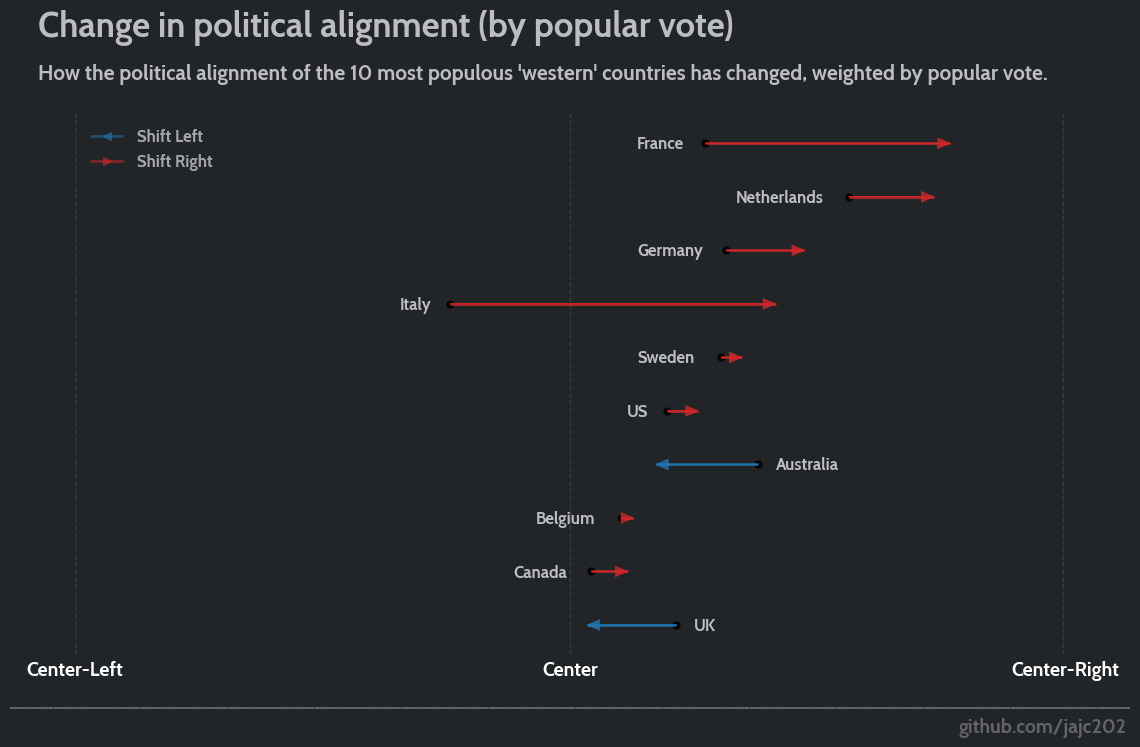

In [9]:
# Create a figure and an axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Define line colors
left_shift_color = "#1f77b4"    # Muted blue (leftward shift)
right_shift_color = "#d62728"   # Muted red (rightward shift)
marker_edge_color = "black"     # Black (previous election)

# Loop through each country and plot the shift
for i in range(len(master_df)):
    # Define current variables
    prev_score = master_df["Previous Political Spectrum Score"][i]
    latest_score = master_df["Latest Political Spectrum Score"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_score < prev_score else right_shift_color
    
    # Plot connecting line
    ax.plot(
        [prev_score, latest_score], 
        [country, country], 
        color=line_color, 
        linestyle="-", 
        linewidth=2, 
        alpha=0.8
    )

    # Plot previous score marker
    ax.scatter(
        prev_score, 
        country, 
        color=marker_edge_color, 
        s=25, 
        label="Previous Score" if i == 0 else "", 
        edgecolor=marker_edge_color, 
        linewidth=0.8
    )
    
    # Add an arrow showing direction
    ax.arrow(
        prev_score, 
        i, 
        latest_score - prev_score, 
        0, 
        head_width=0.2, 
        head_length=0.05, 
        color=line_color, 
        alpha=0.8, 
        length_includes_head=True
    )
    
# Add a vertical lines for -1, 0 and 1
ax.axvline(0, color="white", linestyle="--", linewidth=1, alpha=0.1)
ax.axvline(-2, color="white", linestyle="--", linewidth=1, alpha=0.1)
ax.axvline(1.99, color="white", linestyle="--", linewidth=1, alpha=0.1)

# Add country labels
# UK
ax.text(x = 0.5, y = -0.1,
    s = 'UK',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Candada
ax.text(x = -0.23, y = 0.9,
    s = 'Canada',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Belgium
ax.text(x = -0.14, y = 1.9,
    s = 'Belgium',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Australia
ax.text(x = 0.83, y = 2.9,
    s = 'Australia',fontsize = 12, color = 'white', alpha = .7, ha='left')
# US
ax.text(x = 0.23, y = 3.9,
    s = 'US',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Sweden
ax.text(x = 0.27, y = 4.9,
    s = 'Sweden',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Italy
ax.text(x = -0.69, y = 5.9,
    s = 'Italy',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Germany
ax.text(x = 0.27, y = 6.9,
    s = 'Germany',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Netherlands
ax.text(x = 0.67, y = 7.9,
    s = 'Netherlands',fontsize = 12, color = 'white', alpha = .7, ha='left')
# France
ax.text(x = 0.27, y = 8.9,
    s = 'France',fontsize = 12, color = 'white', alpha = .7, ha='left')

# Add titles and various text
# Title
ax.text(x = -2.15, y = 11,fontsize = 25, color = 'white', alpha = .7, ha='left',
        s = 'Change in political alignment (by popular vote)')
# Subtitle
ax.text(x = -2.15, y = 10.2, fontsize = 15, color = 'white', alpha = .7, ha='left',
        s = 'How the political alignment of the 10 most populous \'western\' countries has changed, weighted by popular vote.')
# Remove y-axis label for a cleaner look
plt.ylabel("")
# Add github link
ax.text(x = 2.25, y = -2, fontsize = 14, color = 'grey', alpha = .7, ha='right',
        s = 'github.com/jajc202')
# Add line for github link
ax.text(x = 0, y = -1.5, color = 'grey', alpha = .7, ha='center',
        s = '_______________________________________________________________________________________________________')

# Set axis ticks
# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
# Apply custom x-ticks
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=14)
# Remove y-ticks
plt.yticks([], [])

# Improve aesthetics
# Limit x-axis
plt.xlim(-2, 2)
# Remove xgrid lines
plt.gca().xaxis.grid(False)
# Remove extra spines
sns.despine(left=True, bottom=True)
# Adjust margins
fig.tight_layout()
fig.subplots_adjust(left=0.075, right=0.9)

# Create legend
# Create legend elements
left_arrow = mlines.Line2D([], [], color=left_shift_color, marker='<', linestyle='-', linewidth=2, label="Shift Left")
right_arrow = mlines.Line2D([], [], color=right_shift_color, marker='>', linestyle='-', linewidth=2, label="Shift Right")
# Add legend to the plot
leg = ax.legend(handles=[left_arrow, right_arrow], loc="upper left", fontsize=12, frameon=False)
# Make legend arrows slightly transparent
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
# Make legend text slightly transparent
for ll in leg.texts: 
    ll.set_alpha(0.6)

# Show the plot
plt.show()

### **Change in Political Alignment by Main Party**

In [10]:
master_df

,Country,Previous Political Spectrum Score,Latest Political Spectrum Score,Previous Majority Party,Latest Majority Party,Alignment Change
0,UK,0.430000,0.070000,3,-2,-0.360000
1,Canada,0.084484,0.232640,-1,-1,0.148156
2,Belgium,0.207070,0.255894,2,2,0.048825
3,Australia,0.759323,0.346381,3,3,-0.412942
4,US,0.392500,0.517513,-2,3,0.125013
5,Sweden,0.608662,0.693772,-2,-2,0.085110
6,Italy,-0.484269,0.830414,-4,5,1.314683
7,Germany,0.628578,0.946423,2,2,0.317845
8,Netherlands,1.125280,1.469460,2,5,0.344180
9,France,0.544989,1.535629,1,6,0.990640


C:\Users\josha\AppData\Local\Temp\ipykernel_3240\2653493823.py:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


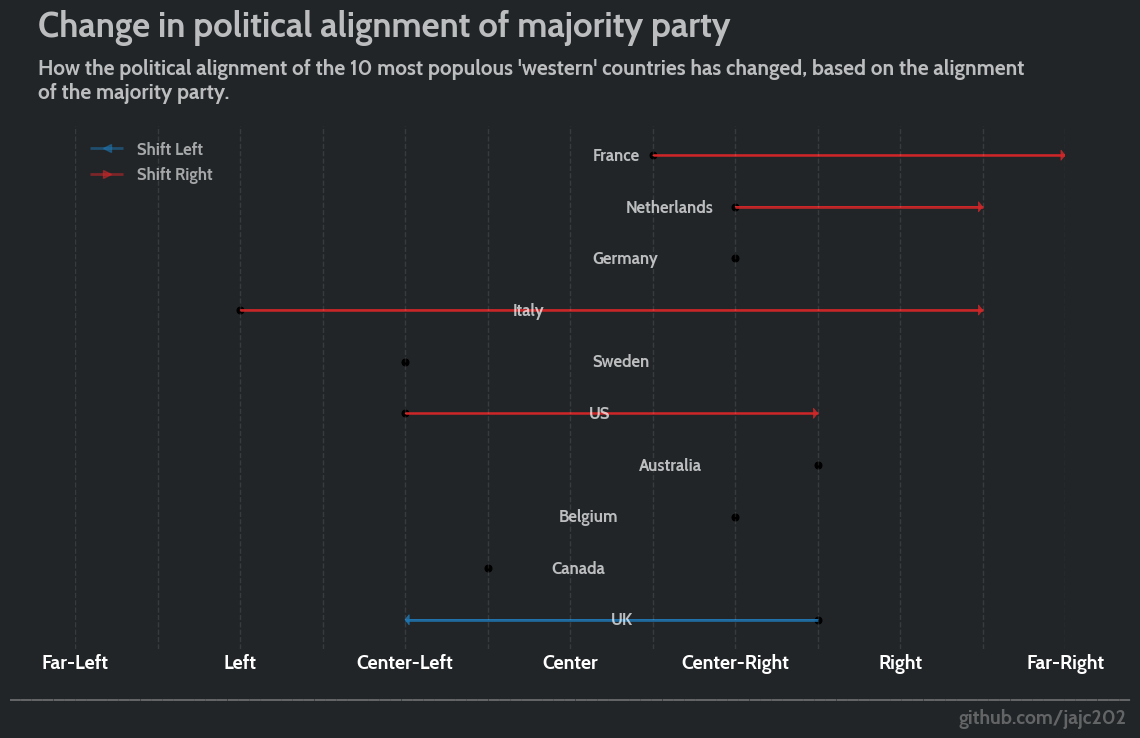

In [38]:
# Create a figure and an axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Define line colors
left_shift_color = "#1f77b4"    # Muted blue (leftward shift)
right_shift_color = "#d62728"   # Muted red (rightward shift)
marker_edge_color = "black"     # Black (previous election)

# Loop through each country and plot the shift
for i in range(len(master_df)):
    # Define current variables
    prev_party_score = master_df["Previous Majority Party"][i]
    latest_party_score = master_df["Latest Majority Party"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_party_score < prev_party_score else right_shift_color
    
    # Plot connecting line
    ax.plot(
        [prev_party_score, latest_party_score], 
        [country, country], 
        color=line_color, 
        linestyle="-", 
        linewidth=2, 
        alpha=0.8
    )

    # Plot previous score marker
    ax.scatter(
        prev_party_score, 
        country, 
        color=marker_edge_color, 
        s=25, 
        label="Previous Party" if i == 0 else "", 
        edgecolor=marker_edge_color, 
        linewidth=0.8
    )
    
    # Add an arrow showing direction
    ax.arrow(
        prev_party_score, 
        i, 
        latest_party_score - prev_party_score, 
        0, 
        head_width=0.2, 
        head_length=0.05, 
        color=line_color, 
        alpha=0.8, 
        length_includes_head=True
    )
    
# Add a vertical lines for -1, 0 and 1
for i in range(-6,7):
    ax.axvline(i, color="white", linestyle="--", linewidth=1, alpha=0.1)
#ax.axvline(0, color="white", linestyle="--", linewidth=1, alpha=0.1)
#ax.axvline(-2, color="white", linestyle="--", linewidth=1, alpha=0.1)
#ax.axvline(1.99, color="white", linestyle="--", linewidth=1, alpha=0.1)

# Add country labels
# UK
ax.text(x = 0.5, y = -0.1,
    s = 'UK',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Candada
ax.text(x = -0.23, y = 0.9,
    s = 'Canada',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Belgium
ax.text(x = -0.14, y = 1.9,
    s = 'Belgium',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Australia
ax.text(x = 0.83, y = 2.9,
    s = 'Australia',fontsize = 12, color = 'white', alpha = .7, ha='left')
# US
ax.text(x = 0.23, y = 3.9,
    s = 'US',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Sweden
ax.text(x = 0.27, y = 4.9,
    s = 'Sweden',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Italy
ax.text(x = -0.69, y = 5.9,
    s = 'Italy',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Germany
ax.text(x = 0.27, y = 6.9,
    s = 'Germany',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Netherlands
ax.text(x = 0.67, y = 7.9,
    s = 'Netherlands',fontsize = 12, color = 'white', alpha = .7, ha='left')
# France
ax.text(x = 0.27, y = 8.9,
    s = 'France',fontsize = 12, color = 'white', alpha = .7, ha='left')

# Add titles and various text
# Title
ax.text(x = -6.45, y = 11.3,fontsize = 25, color = 'white', alpha = .7, ha='left',
        s = 'Change in political alignment of majority party')
# Subtitle
ax.text(x = -6.45, y = 10.1, fontsize = 15, color = 'white', alpha = .7, ha='left',
        s = 'How the political alignment of the 10 most populous \'western\' countries has changed, based on the alignment \nof the majority party.')
# Remove y-axis label for a cleaner look
plt.ylabel("")
# Add github link
ax.text(x = 6.75, y = -2, fontsize = 14, color = 'grey', alpha = .7, ha='right',
        s = 'github.com/jajc202')
# Add line for github link
ax.text(x = 0, y = -1.5, color = 'grey', alpha = .7, ha='center',
        s = '_______________________________________________________________________________________________________')

# Set axis ticks
# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
# Apply custom x-ticks
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=14)
# Remove y-ticks
plt.yticks([], [])

# Improve aesthetics
# Limit x-axis
plt.xlim(-6, 6)
# Remove xgrid lines
plt.gca().xaxis.grid(False)
# Remove extra spines
sns.despine(left=True, bottom=True)
# Adjust margins
fig.tight_layout()
fig.subplots_adjust(left=0.075, right=0.9)

# Create legend
# Create legend elements
left_arrow = mlines.Line2D([], [], color=left_shift_color, marker='<', linestyle='-', linewidth=2, label="Shift Left")
right_arrow = mlines.Line2D([], [], color=right_shift_color, marker='>', linestyle='-', linewidth=2, label="Shift Right")
# Add legend to the plot
leg = ax.legend(handles=[left_arrow, right_arrow], loc="upper left", fontsize=12, frameon=False)
# Make legend arrows slightly transparent
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
# Make legend text slightly transparent
for ll in leg.texts: 
    ll.set_alpha(0.6)

# Show the plot
plt.show()